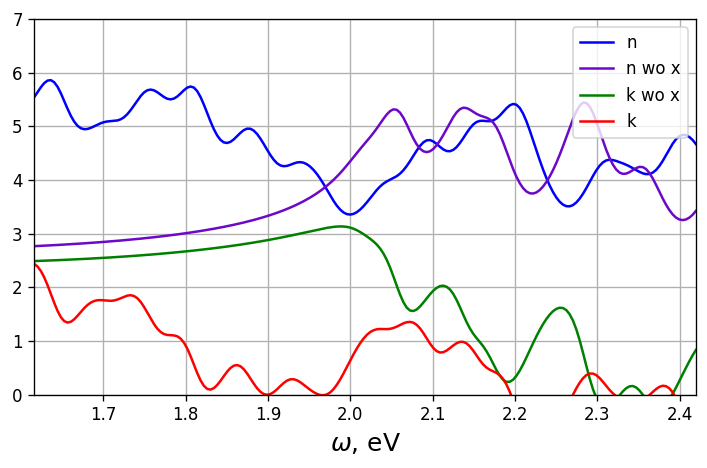

In [12]:
import mdirac as moire
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')
import shutil
import json
import matplotlib.pyplot as plt
import time

a = 1.9188*np.sqrt(3) # [A] Bieneck (2020) DFT WSe2
a0 = 0.52917 # [A] hydrogen 
r0 = 45 # [A] Nguyen WSe2 (2022) 
Eg = 2.02 # [eV] Nguyen WSe2 (2022)
Ry = 13.60565 # [eV] hydrogen
#me = 0.29 # [m0] Kormanyos WSe2 (2015)
#mh = 0.36 # [m0] Kormanyos WSe2 (2015)
m = 0.3
epstop = 1 # air
epsbottom = 1 # freestanding
eps = 0.5*(epstop+epsbottom)

Ry = Ry/Eg
t = np.sqrt(0.5*Ry*(1/m))*a0/a # in units of Eg
teff = 2*np.pi*t # 2pi from 2pi/a in monolayer hamiltonian

#keldysh interaction parameters
r0eff = 2*np.pi*r0/a
epseff = eps/Ry*a/a0/2

#optical slab model for transition from sigma to epsilion
d = 6.5 # [A], MoS2 thickness
beta = Ry*2*a0/d 

#grid density 
kstep0 = 0.03
scale=0.4
#cell=kstep0*np.array([[1.,0.],[-0.5,0.5*np.sqrt(3)]])
# complicable with moire hamiltonian reciprocal vectors
cell=kstep0*np.array([[0.5*np.sqrt(3),0.5],[-0.5*np.sqrt(3),0.5]])
N = int(1/kstep0)
kmesh = moire.mesh.Parallelogram(N,cell)

deg = 4 # valley+spin degeneracy

def mkdir_p(mypath):
    from errno import EEXIST
    try:
        os.makedirs(mypath)
    except OSError as exc:
        if exc.errno == EEXIST and os.path.isdir(mypath):
            pass
        else: raise

path = 'out/mono/WS2/run1/'+'scale'+str(scale)+'kstep0_'+str(kstep0)
mkdir_p(path)

circle = kmesh.get_BZ(scale=0.4)
meshpath = '/mesh.png'
circle.savefig(path=(path+meshpath))

f = open('mono.ipynb')
data = json.load(f)
log = data['cells'][0]['source']
f.close()
out_f = open(path+"/log.json", "w")
json.dump(log, out_f, indent = 6)
out_f.close()

timelog = open(path+"/timelog.txt", "w")
startTime = time.time()
E,U = moire.mdirac.eighMesh(circle,teff)
executionTime = (time.time() - startTime)
timelog.write("Hamiltonian diagonalization time: " + str(executionTime) + '\n')


plt.plot(np.arange(E[:,1].shape[0]),E[:,1])
plt.savefig(path+'/disps_c.png',dpi=100)
plt.close()

plt.plot(np.arange(E[:,0].shape[0]),E[:,0])
plt.savefig(path+'/disps_v.png',dpi=100)
plt.close()

keld=moire.interaction.Keldysh(epseff,r0eff,kstep0)
Wk=moire.interaction.sample_to_mesh(keld,kmesh)
Wklog = open(path+"/Wklog.txt", "w")
Wklog.write('k space, singularity resolved with integration over parallelogram -> 4.254' + '\n')
Wklog.write('Wk[0,0] '+str(Wk[0,0]) + '\n')
Wklog.write('Wk[0,1] '+str(Wk[0,1]))
Wklog.close()

keldpath = '/keld.png'
kmesh.savefig(c=np.log(np.abs(Wk)),path=(path+keldpath),dpi=100,s=100)

startTime = time.time()
Wkk=moire.interaction.pairs(circle,Wk)
executionTime = (time.time() - startTime)
timelog.write("Keldysh pairing time: " + str(executionTime) + '\n')

Ex=np.zeros((circle.Np,2,2),dtype=np.float64)
Ux=np.zeros((circle.Np,circle.Np,2,2),dtype=np.complex128)

startTime = time.time()
H = moire.mdirac.Hbse(E,U,Wkk)
Ex, Ux = np.linalg.eigh(H)
executionTime = (time.time() - startTime)
timelog.write("BSE diagonalization time: " + str(executionTime) +'\n')

Exlog = open(path+"/Exlog.txt", "w")
Exlog.write('Exciton energies in energy units of gap: \n')
Exlog.write(str(Ex[:5]) + '\n')
Exlog.write('Exciton energies in eV energy units: \n')
Exlog.write(str(Eg*Ex[:5]) + '\n')
Eb=Eg*(1.-Ex[:5])
Exlog.write('Exciton binding energies in eV: \n')
Exlog.write(str(Eb[:5]))
Exlog.close()

startTime = time.time()
sx=np.array([[0,1],[1,0]])
factorsigma=deg*kmesh.vcell*2*Ry*(a0/a)**2*(1/m)/1.j
omega=np.linspace(1.e-5,2.,1000)
eta=1.5e-2
csxv=np.zeros((circle.Np),dtype=np.complex)
xsx0=np.zeros((circle.Np),dtype=np.complex)
dE=np.zeros((circle.Np),dtype=np.float64)

sigma=np.zeros((omega.shape[0]),dtype=np.complex128)
sigma0=np.zeros((omega.shape[0]),dtype=np.complex128)

csxv = moire.mdirac.cov_matrix_elements(sx,U,1,0)
xsx0 = moire.mdirac.exciton_elements(Ux,csxv)
dE = E[:,1]-E[:,0]

sigma0=moire.mdirac.get_sigma(factorsigma,omega-1.j*eta,dE,csxv)
sigma=moire.mdirac.get_sigma(factorsigma,omega-1.j*eta,Ex,xsx0)
executionTime = (time.time() - startTime)
timelog.write("Matrix element calculation: " + str(executionTime))


fsumlog = open(path+"/fsum.txt", "w")
fsumlog.write('Transition sum rules for different transitions in order 0123 -> 12,13,02,03: \n')
fsumlog.write(str(np.sum(np.abs(csxv)**2))+'\t'+str(np.sum(np.abs(xsx0)**2))+'\n')
fsumlog.close()


cutoff=50
scaleomega=Eg/500
omegas = np.arange(omega.shape[0])[cutoff:]
plt.plot(scaleomega*omegas,sigma0.real[cutoff:],c='b',label='ReSigma wo x')
plt.plot(scaleomega*omegas,sigma.real[cutoff:],c='r',label='ReSigma')
plt.xlabel(r'$\omega$, eV',fontsize=15)
plt.ylabel(r'Re $\sigma$',fontsize=15)
realsigmapath = path + '/realsigma.png'
plt.savefig(realsigmapath,dpi=120)
plt.close()
plt.plot(scaleomega*omegas,sigma.imag[cutoff:],c='r',label='ImSigma')
plt.plot(scaleomega*omegas,sigma0.imag[cutoff:],c='b',label='ImSigma wo x')
plt.xlabel(r'$\omega$, eV',fontsize=15)
plt.ylabel(r'Im $\sigma$',fontsize=15)
imsigmapath = path + '/imsigma.png'
plt.savefig(imsigmapath,dpi=120)
plt.close()

eps = 1+4*np.pi*sigma0[cutoff:]/omega[cutoff:]*beta
refr = np.sqrt(eps)
eps_x = 1+4*np.pi*sigma[cutoff:]/omega[cutoff:]*beta
refr_x = np.sqrt(eps_x)

fig,ax=plt.subplots(dpi=120)
ax.plot(scaleomega*omegas,refr_x.real,'b',label='n')
ax.plot(scaleomega*omegas,refr.real,c='#6C09C9',label='n wo x')
ax.plot(scaleomega*omegas,refr.imag,c='g',label='k wo x')
ax.plot(scaleomega*omegas,refr_x.imag,'r',label='k')
ax.set_xlim([scaleomega*omegas[0],scaleomega*omegas[-1]])
ax.set_ylim([0,5])
ax.set_xlabel(r'$\omega$, eV',fontsize=15)
ax.grid()
ax.legend(loc='upper right')
fig.tight_layout()
optconstspath = path + '/optconsts.png'
plt.savefig(optconstspath)

sigmatofile = np.column_stack([scaleomega*omegas, sigma.real[cutoff:]])
np.savetxt(path+'/Resigma.txt',sigmatofile)

ktofile = np.column_stack([scaleomega*omegas, refr_x.imag])
np.savetxt(path+'/extinction.txt',ktofile)

left=400 # 0.1Delta below and on top of gap
right=600 
omegas = np.arange(omega.shape[0])[left:right]
eps = 1+4*np.pi*sigma0[left:right]/omega[left:right]*beta
refr = np.sqrt(eps)
eps_x = 1+4*np.pi*sigma[left:right]/omega[left:right]*beta
refr_x = np.sqrt(eps_x)

plt.plot(scaleomega*omegas,sigma0.real[left:right],c='b',label='ReSigma wo x')
plt.plot(scaleomega*omegas,sigma.real[left:right],c='r',label='ReSigma')
plt.xlabel(r'$\omega$, eV',fontsize=15)
plt.ylabel(r'Re $\sigma$',fontsize=15)
realsigmapathcut = path + '/realsigmacut.png'
plt.savefig(realsigmapathcut,dpi=120)
plt.close()

fig,ax=plt.subplots(dpi=120)
ax.plot(scaleomega*omegas,refr_x.real,'b',label='n')
ax.plot(scaleomega*omegas,refr.real,c='#6C09C9',label='n wo x')
ax.plot(scaleomega*omegas,refr.imag,c='g',label='k wo x')
ax.plot(scaleomega*omegas,refr_x.imag,'r',label='k')
ax.set_xlim([scaleomega*omegas[0],scaleomega*omegas[-1]])
ax.set_ylim([0,7])
ax.set_xlabel(r'$\omega$, eV',fontsize=15)
ax.grid()
ax.legend(loc='upper right')
fig.tight_layout()
optconstspath = path + '/optconstscut.png'
plt.savefig(optconstspath)

timelog.close()

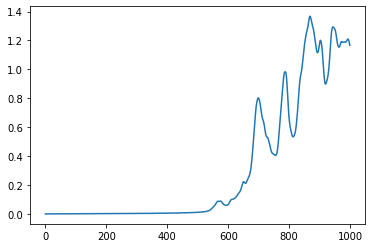

In [71]:
plt.plot(np.sum(sigma0,axis=(1,2)))